YOU CAN VIEW THIS NOTEBOOK INCLUDING THE GRAPHICS USING THIS LINK: https://nbviewer.jupyter.org/github/DCMLab/schubert_dances/blob/master/schubert_project.ipynb

# Prerequisites
This is a tested setup using a new conda environment. If you're fine with running **Jupyter Notebook**, these commands will do (where `schubert` is the arbitrary name of the new environment):

    conda create -n schubert python=3.7 nb_conda_kernels jupyter
    conda activate schubert
    conda install -c plotly plotly-orca psutil requests
    python -m pip install cufflinks Beautifulsoup4 lxml

If, in addition, you want to use **Jupyter Lab**, you will need to follow these instructions taken from https://plot.ly/python/getting-started/#jupyterlab-support-python-35:

Install via `pip`:

    python -m pip install jupyterlab==1.2 ipywidgets>=7.5
    
or `conda:`

    conda install -c conda-forge jupyterlab=1.2
    conda install "ipywidgets=7.5"
    
Set system variable to avoid "JavaScript heap out of memory" errors during extension installation:

    # (OS X/Linux)
    export NODE_OPTIONS=--max-old-space-size=4096
    # (Windows)
    set NODE_OPTIONS=--max-old-space-size=4096

Then, run the following commands:

    jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.1 --no-build
    jupyter labextension install jupyterlab-plotly@1.3.0 --no-build
    jupyter labextension install plotlywidget@1.3.0 --no-build
    jupyter lab build

Then you can unset the system variable again:

    # (OS X/Linux)
    unset NODE_OPTIONS
    # (Windows)
    set NODE_OPTIONS=

In [1]:
%load_ext autoreload
%autoreload 2
from tools.ms3 import *
import scipy as sp
from plotly.offline import iplot
import cufflinks as cf # for creating plots from pandas on the fly
import plotly.io as IO
cf.go_offline()
cf.set_config_file(theme='ggplot') #{'solar', 'pearl', 'white', 'ggplot'}

# Configuration 

In [2]:
compute_all = False                              # Sets all 'compute_anew' flags to True
logging.getLogger().setLevel(logging.WARNING)    # logging level
data ='data'                                     # data folders
data_ms3 = os.path.join(data,'MuseScore_3')
data_tsv = os.path.join(data,'tsv')
note_features = None                             # TODO: Pass selected features as kwargs to get_notes()
#plt.rcParams['figure.figsize'] = [15,10]         # Change the plotsize for the entire notebook

# Loading the data
The dataframe `merged_ids` maps the 435 IDs to the files in the `data_ms3` folder. The different types of trios (trio I, trio II, alternative trio) are all replaced by the term 'trio'.

In [3]:
merged_ids = os.path.join(data_ms3, 'merged_ids.tsv')
files = pd.read_csv(merged_ids, sep='\t', index_col=0)
files.loc[files.dance.str.contains('trio'), 'dance'] = 'trio'
files.head()

,D,no,dance,path
id,,,,
1,41,1,menuett,041/D041menuett01a.mscx
2,41,1,trio,041/D041trio01b.mscx
3,41,2,menuett,041/D041menuett02a.mscx
4,41,2,trio,041/D041trio02b.mscx
5,41,3,menuett,041/D041menuett03a.mscx


#### Accessibility
We check whether all files are accessible.

In [4]:
missing = [file for file in files.path.values if not os.path.isfile(os.path.join(data_ms3, file))]
if missing != []:
    print("These files are missing:\n" + '\n'.join(missing))
else:
    print("All files found.")

All files found.


## Computing or loading the DataFrame representation of the music
We will be working on the data set in the form of note_lists. These can be newly computed from the scores or loaded from the precomputed TSV.

In [5]:
compute_anew = False

if compute_anew:
    
    def get_note_list(df):
        S = Score(os.path.join(data_ms3,df.iloc[0].path))
        return S.get_notes()
    
    note_list = files.groupby('id').apply(get_note_list)
    note_list.to_csv(os.path.join(data_tsv, 'note_list_complete.tsv'), sep='\t')
else:
    note_list = pd.read_csv(os.path.join(data_tsv, 'note_list_complete.tsv'), sep='\t', index_col=[0,1,2], dtype={'tied': 'Int64', 'volta': 'Int64'}, converters={'onset':frac, 'duration':frac, 'nominal_duration':frac, 'scalar':frac})
note_list.head()

mc  mn onset duration gracenote nominal_duration scalar  tied  \
id section ix                                                                  
1  0       0    0   0     0     3/16       NaN              1/8    3/2   NaN   
           1    0   0     0     3/16       NaN              1/8    3/2   NaN   
           2    0   0  3/16     1/16       NaN             1/16      1   NaN   
           3    0   0  3/16     1/16       NaN             1/16      1   NaN   
           4    1   1     0      1/4       NaN              1/4      1   NaN   

               tpc  midi  staff  voice  volta  
id section ix                                  
1  0       0     3    57      1      1    NaN  
           1    -1    65      1      1    NaN  
           2     3    57      1      1    NaN  
           3    -1    65      1      1    NaN  
           4    -1    41      2      1    NaN

# Basic statistics

### Pieces per dance type

The corpus contains 435 pieces. The different types are distributed as follows:
walzer       132
ländler       78
ecossaise     74
deutscher     71
trio          48
menuett       29
galopp         2
cotillon       1
Name: dance, dtype: int64


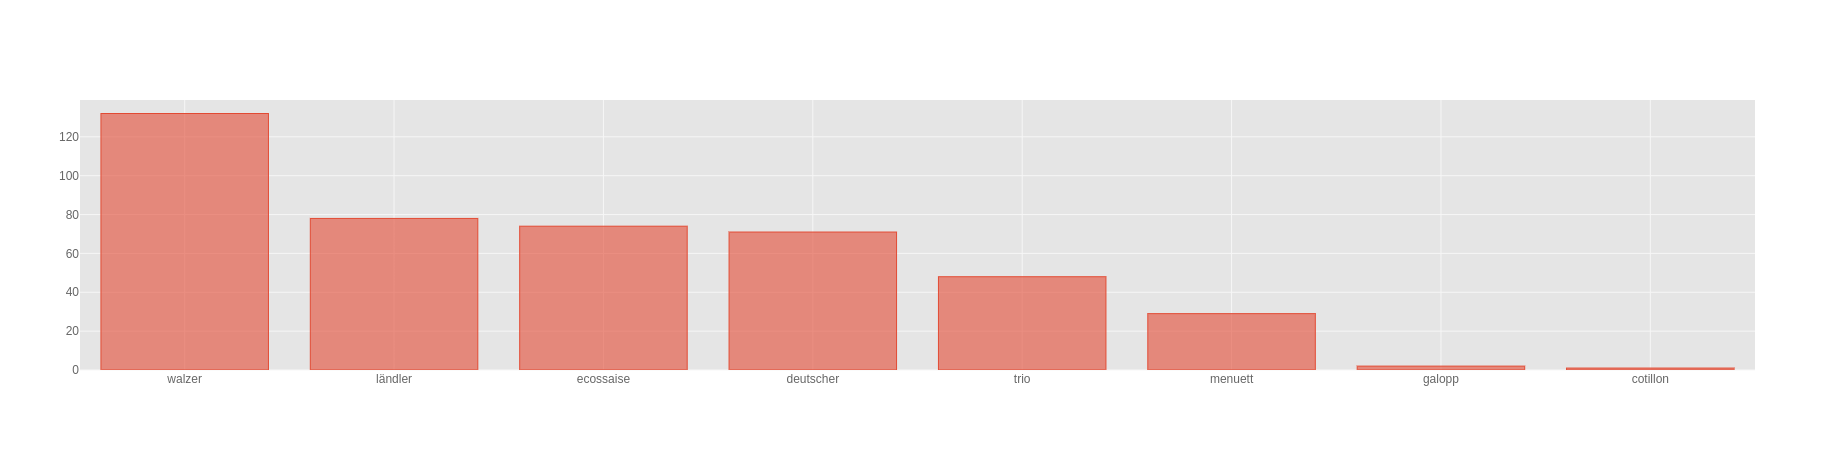

In [6]:
dance_types = files.dance.value_counts()
print(f"The corpus contains {len(files.index)} pieces. The different types are distributed as follows:{NL}{dance_types}")
dance_types.iplot('bar')

### Number and distribution of notes

In [7]:
f"The data set has {len(note_list.index)} note events in total, and {len(note_list.index[note_list.gracenote.isna()])} notes omitting grace notes."

'The data set has 101810 note events in total, and 101231 notes omitting grace notes.'

In [8]:
def bag_of_notes(df):
    """Input: DataFrame including the columns ['tpc', 'duration']"""
    tpcs = df.tpc
    occurring = np.sort(tpcs.unique())
    note_names = spell_tpc(occurring)
    bag = pd.DataFrame(index=occurring, columns=['count_a', 'count_n', 'duration_a', 'duration_n'])
    GB = df.groupby('tpc')
    bag.count_a = GB.size()
    bag.count_n = bag.count_a / bag.count_a.sum()
    bag.duration_a = GB['duration'].sum().astype(float)
    bag.duration_n = (bag.duration_a / bag.duration_a.sum()).astype(float)
    bag.index = note_names
    return bag

tpc_distribution = bag_of_notes(note_list)

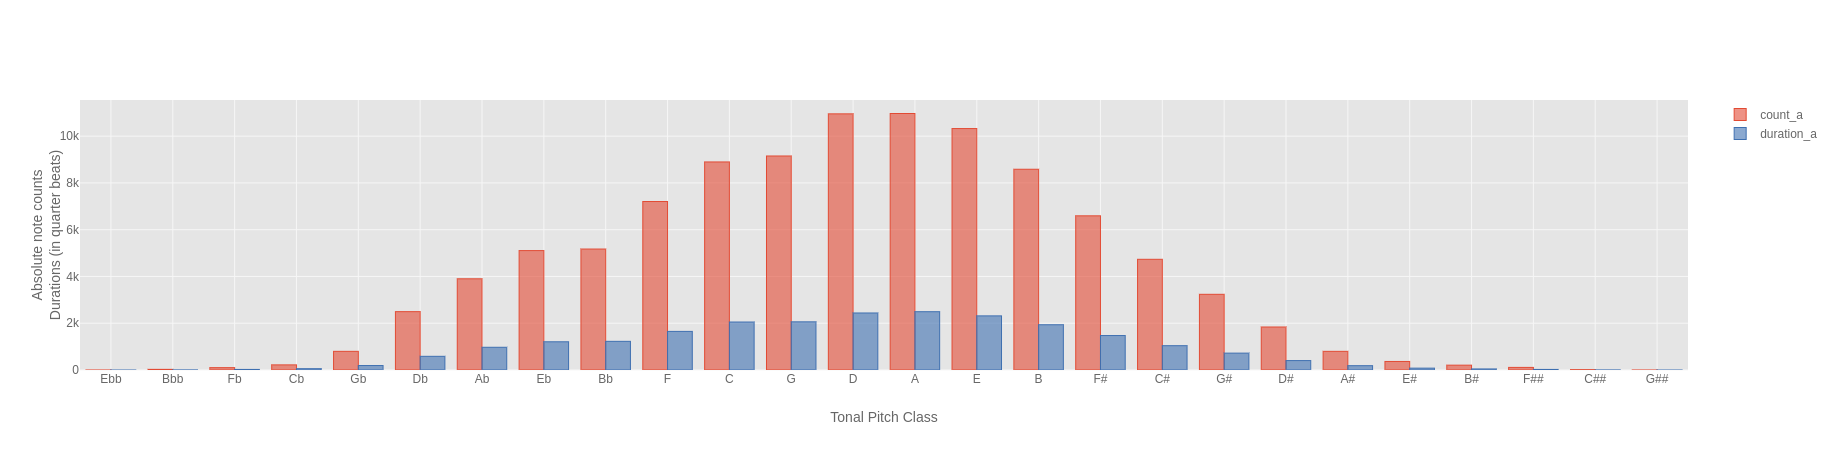

In [9]:
tpc_distribution[['count_a', 'duration_a']].iplot('bar', xTitle='Tonal Pitch Class', yTitle='Absolute note counts<br>Durations (in quarter beats)')

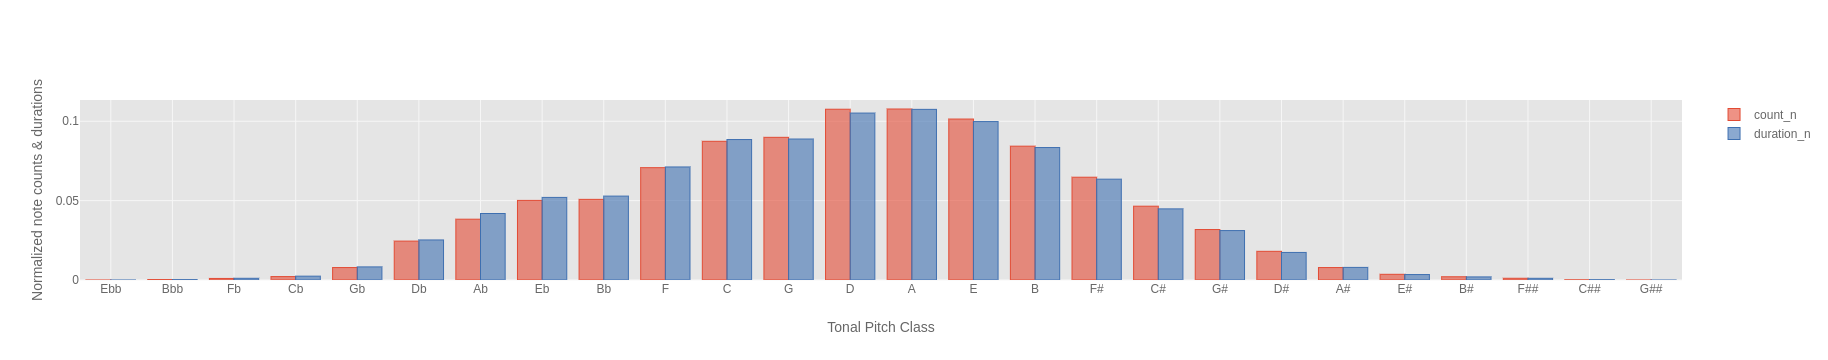

In [10]:
tpc_distribution[['count_n', 'duration_n']].iplot('bar', xTitle='Tonal Pitch Class', yTitle='Normalized note counts & durations')

In [11]:
temp = []
for dance in DANCES.index:
    if dance in failed_parse:
        temp += [np.nan]
    else:
        notes = notes_bag(dance)
        temp += [float(sp.stats.entropy(notes.dropna())/np.log(35))]
    
DANCES['entropy'] = temp

NameError: name 'DANCES' is not defined

In [ ]:
DANCES.head(10)

In [ ]:
DANCES.entropy.hist();

In [ ]:
DANCES.groupby('Type').entropy.mean()

In [ ]:
def keysig(n):
    return Score(DANCES.File[n]).mc_info[0].keysig[0]

In [ ]:
temp = []
for i in DANCES.index:
    if i in failed_parse:
        temp += [np.nan]
    else:
        temp += [keysig(i)]

DANCES['Keysig'] = temp

In [ ]:
sp.stats.pearsonr(DANCES.dropna().entropy, DANCES.dropna().Keysig )

In [ ]:
plt.scatter(DANCES.dropna().Keysig, DANCES.dropna().entropy);

In [ ]:
def KK(mode, transposition):
    """Krumhansl and Kessler (1982) key profiles for major and minor modes"""
    
    major = [6.20, 2.55, 3.45, 2.85, 4.22, 4.57, 2.67, 5.25, 2.45, 3.35, 2.70, 2.70]
    minor = [6.03, 3.35, 3.67, 5.28, 2.58, 3.55, 2.87, 4.80, 4.35, 2.67, 2.50, 3.42]
    
    #major = list(map(lambda x: x/sum(major), major))
    #minor = list(map(lambda x: x/sum(minor), minor))
    
    if mode == 0:
        return major[-transposition:]+major[:-transposition]
    elif mode == 1:
        return minor[-transposition:]+minor[:-transposition]
    else:
        print('0 = major, 1 = minor')